# Data Preprocessing and Data Analysis

#### Written by Carlos Cuevas Villarmín 

Last update: 08/02/2024

**0. Import libraries**

In [1]:
import sys, os
import pandas as pd
import numpy as np

from utils_preprocessing import *

**1. Transform Brat format into BIO.**

To do that I am going to use the following repository [https://github.com/nlplab/brat/tree/master]. In particular, the file antoconll.py

In [2]:
#Load the brat tools
sys.path.append('brat/tools')
sys.path.append('brat/server/src')

from brat.tools.anntoconll import main

In [3]:
#Read the text roots from the data folder
txt_files = ['data/'+file for file in os.listdir('data/') if file.endswith(".txt")]
#Run the brat tools on the text files to generate the conll files
main(['-']+txt_files) #The - is a dummy argument to make the brat tools work


**2. Read the documents and create the DataFrame**

Now, once the data has been transformed into BIO format in the .conll files the following step is to read these files and create a DataFrame with the information of the files adding the File_ID the information belongs to. Additionally, to add later a column with the Sentence_ID at each file the blank lines of the files will be set to NaN to consider it as a separator.

In [4]:
data = {'File_ID': [], 'Entity': [], 'Start': [], 'End': [], 'Words': []}

#Read the root of .conll files
conll_files = [file for file in os.listdir('./data/') if file.endswith(".conll")]

for file in conll_files:
    #Read the files
    file_path = os.path.join('./data/', file)
    with open(file_path, "r") as f:
        lines = f.readlines()

        #Add the info of each line of 'file' to the data dict
        for line in lines:
            data['File_ID'].append(file.split('.')[0])
            line = line.split()
            if len(line)>0:
                data['Entity'].append(line[0])
                data['Start'].append(line[1])
                data['End'].append(line[2])
                data['Words'].append(line[3])
            else: #For blank lines
                data['Entity'].append(np.nan)
                data['Start'].append(np.nan)
                data['End'].append(np.nan)
                data['Words'].append(np.nan)

#Transform data dict into DataFrame
data_df = pd.DataFrame(data)

#Report the shape and an overview of the DataFrame
print(f"Length of the data: {data_df.shape}")
data_df

Length of the data: (399068, 5)


,File_ID,Entity,Start,End,Words
0,24599578,O,0,1,A
1,24599578,O,2,13,multicenter
2,24599578,O,14,24,randomized
3,24599578,O,25,30,trial
4,24599578,O,31,33,of
...,...,...,...,...,...
399063,17363187,O,1760,1765,local
399064,17363187,O,1766,1769,and
399065,17363187,O,1770,1777,overall
399066,17363187,O,1778,1785,relapse


In order to illustrate the effect of blank lines, print the first 30 lines of the DataFrame in order to see one of these separator rows.

In [5]:
data_df[0:30]

,File_ID,Entity,Start,End,Words
0,24599578,O,0,1,A
1,24599578,O,2,13,multicenter
2,24599578,O,14,24,randomized
3,24599578,O,25,30,trial
4,24599578,O,31,33,of
5,24599578,O,34,37,the
6,24599578,O,38,45,effects
7,24599578,O,46,48,of
8,24599578,B-intervention,49,57,exercise
9,24599578,O,58,62,dose


Each sentence is separated by a blank line. In row 22 of the DataFrame, makes evident that in such cases, all the values are NaN. This structure provides the opportunity to add a sentenceID to each word, allowing us to identify all the words belonging to the same sentence.

**3. Clean the DataFrame**

**3.1. Add Sentece_ID column.** We will define a counter which will be the sentence where the word appears if label value or word value is not NaN. Otherwise, the Sentence_ID will be 0, i.e., in the cases of a blank line or sentence separator. Finally, I remove all rows with sentenceID=0 in order to not count the separators.

In [6]:
# Create list of sentences and counter
ls = []
counter = 1

for i in range(len(data_df)):
    # If the current line is not a sentence separator, we add the current counter to the list
    if ((pd.isna(data_df.Words[i]) == False) | (pd.isna(data_df.Entity[i]) == False)):
        ls.append(counter)
    # If the current line is a sentence separator, we add 0 to the list and increase the counter by 1
    if ((pd.isna(data_df.Words[i]) == True) & (pd.isna(data_df.Entity[i]) == True)):
        ls.append(0)
        counter += 1 
        
# We add the list to the dataframe        
data_df['Sentence_ID'] = ls

# Drop rows with data['Sentence_ID'] == 0 (blank lines)
data_df = data_df[data_df['Sentence_ID'] != 0]

In [7]:
print(f"Length of the data: {data_df.shape}")
#Visualize the data after adding the Sentence_ID and dropping the blank lines
data_df

Length of the data: (387101, 6)


,File_ID,Entity,Start,End,Words,Sentence_ID
0,24599578,O,0,1,A,1
1,24599578,O,2,13,multicenter,1
2,24599578,O,14,24,randomized,1
3,24599578,O,25,30,trial,1
4,24599578,O,31,33,of,1
...,...,...,...,...,...,...
399063,17363187,O,1760,1765,local,11968
399064,17363187,O,1766,1769,and,11968
399065,17363187,O,1770,1777,overall,11968
399066,17363187,O,1778,1785,relapse,11968


**3.2. Confirm NaN values.** Confirm that now there are not NaN values in the DataFrame.

In [8]:
#Confirm if there still exist any NaN values
data_df.isnull().sum()

File_ID        0
Entity         0
Start          0
End            0
Words          0
Sentence_ID    0
dtype: int64

**3.3. Change data types of the columns.** Change the columns to its correspondent type.

In [9]:
#Confirm the type of each column
data_df.dtypes

File_ID        object
Entity         object
Start          object
End            object
Words          object
Sentence_ID     int64
dtype: object

In [10]:
#Change the type of the column 'Start' and 'End' to int
data_df['Start']  = data_df['Start'].astype(int)
data_df['End']    = data_df['End'].astype(int)

data_df.dtypes

/tmp/ipykernel_13728/598901919.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['Start']  = data_df['Start'].astype(int)
/tmp/ipykernel_13728/598901919.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['End']    = data_df['End'].astype(int)


File_ID        object
Entity         object
Start           int64
End             int64
Words          object
Sentence_ID     int64
dtype: object

In [11]:
#Save into csv file
data_df.to_csv('./DataProcessed/dataBIO_v3.csv', index=False)

**4. Data Analysis**

**4.1.Corpus statistics.** In this section I try to replicate the results obtained in Table 1 of the document [https://aclanthology.org/2022.wiesp-1.4.pdf] where the authors present the frequency of each entity
(sub-category) and the number of abstracts in which
each entity is found.

In [12]:
#Create a copy of the dataframe
data2_df = data_df.copy()

#Drop the rows where the Entity is O because it is not an entity of interest
data2_df = data2_df[data2_df['Entity'] != 'O']

#Count values of the column 'Entity' that start with 'B-' because it determines the number of elements per entity
Freq = pd.DataFrame(data2_df['Entity'].value_counts())

#Drop the rows where the index starts with 'I-'
Freq = Freq[Freq.index.str.startswith('I-') == False]
Freq

#Add the number of fileID uniques where each label appears
Freq['n_files'] = data2_df.groupby('Entity')['File_ID'].nunique()

#Re-order the labels to be in the same order as in the paper mentioned
Freq = Freq.reindex(['B-total-participants', 'B-intervention-participants','B-control-participants', 'B-age', 'B-eligibility', 'B-ethinicity', 'B-condition', 'B-location', 'B-intervention', 'B-control', 'B-outcome', 'B-outcome-Measure', 'B-iv-bin-abs', 'B-cv-bin-abs', 'B-iv-bin-percent', 'B-cv-bin-percent', 'B-iv-cont-mean', 'B-cv-cont-mean', 'B-iv-cont-median', 'B-cv-cont-median', 'B-iv-cont-sd', 'B-cv-cont-sd', 'B-iv-cont-q1', 'B-cv-cont-q1', 'B-iv-cont-q3', 'B-cv-cont-q3'])

#Sum the values of the column 'count'
print(f'Total number of entities: {Freq["count"].sum()}') #Article: 17739

Freq

Total number of entities: 17719


,count,n_files
Entity,,
B-total-participants,1093,847
B-intervention-participants,887,674
B-control-participants,784,647
B-age,231,210
B-eligibility,925,864
B-ethinicity,101,83
B-condition,327,321
B-location,186,168
B-intervention,1067,1011


There exist a mismatch between the frequencies obtained and the ones reported in the paper. For example, in the case of outcome we count the entity 5038 times while in the authors original report the value 5053. I will analyze in depth what is happening to clarify the methodology followed by the authors given the lack of information. The first step is to create a DataFrame with the frequency values obtained and the ones reported by the authors. Additionally, I will add columns that report the differences between the frequencies.

In [13]:
#Prepare the labels
list_B_labels = ['B-total-participants', 'B-intervention-participants','B-control-participants', 'B-age', 'B-eligibility', 'B-ethinicity', 'B-condition', 'B-location', 'B-intervention', 'B-control', 'B-outcome', 'B-outcome-Measure', 'B-iv-bin-abs', 'B-cv-bin-abs', 'B-iv-bin-percent', 'B-cv-bin-percent', 'B-iv-cont-mean', 'B-cv-cont-mean', 'B-iv-cont-median', 'B-cv-cont-median', 'B-iv-cont-sd', 'B-cv-cont-sd', 'B-iv-cont-q1', 'B-cv-cont-q1', 'B-iv-cont-q3', 'B-cv-cont-q3']
list_I_labels = [label.replace('B-', 'I-') for label in list_B_labels]
list_ann_labels = [label.replace('B-', '') for label in list_B_labels]

I define a function to identify the entities where there is a mismatch between the number of .ann files the entity appears in and the number of File_ID where the entity is in the DataFrame.

In [14]:
freq_values = {}
files = ReadFiles('./data/')
for B_label, ann_label in zip(list_B_labels, list_ann_labels):
    print(f"\n{B_label} - {ann_label}")
    freq_values[ann_label] = CountNumberFiles(files, B_label, ann_label, data_df, Freq)


B-total-participants - total-participants
The number of files is EQUAL.
Frequency of B-total-participants in the data: 1093

B-intervention-participants - intervention-participants
The number of files is EQUAL.
Frequency of B-intervention-participants in the data: 887

B-control-participants - control-participants
The number of files is EQUAL.
Frequency of B-control-participants in the data: 784

B-age - age
The number of files is DIFFERENT.
Number of files where age is in the .ann file: 213
Number of files where B-age is in the data: 210
Frequency of B-age in the data: 231

B-eligibility - eligibility
The number of files is EQUAL.
Frequency of B-eligibility in the data: 925

B-ethinicity - ethinicity
The number of files is EQUAL.
Frequency of B-ethinicity in the data: 101

B-condition - condition
The number of files is DIFFERENT.
Number of files where condition is in the .ann file: 322
Number of files where B-condition is in the data: 321
Frequency of B-condition in the data: 327

B-

Now I add to the dictionary the authors frequency reported and create a DataFrame with all the information. Then I compute the differences between the count frequency columns and the number of files each frequency appears in.

In [15]:
#Values of the paper
tag_count_paper = [1094, 887, 784, 231, 925, 101, 327, 186, 1067, 979, 5053, 1081, 556, 465, 1376, 1148, 366, 327, 270, 247, 129, 124, 4, 4, 4, 4]
n_abstracts_paper = [847, 674, 647, 210, 864, 83, 321, 168, 1011, 949, 978, 413, 288, 258, 561, 520, 154, 154, 140, 133, 69, 67, 3, 3, 3, 3]

#Add the values of the paper to the dictionary freq_values
for i, label in enumerate(list_ann_labels):
    freq_values[label]['count_paper'] = tag_count_paper[i]
    freq_values[label]['n_abstracts_paper'] = n_abstracts_paper[i]

#Define a dataframe with the values of the dictionary freq_values
df_freq_values = pd.DataFrame(freq_values).T

#Compute the difference columns
df_freq_values['diff_count'] = df_freq_values['count'] - df_freq_values['count_paper']
df_freq_values = df_freq_values[['count', 'count_paper', 'diff_count', 'n_dataframe', 'n_abstracts_paper', 'n_ann_files']]
df_freq_values['diff_df_abstract'] = df_freq_values['n_dataframe'] - df_freq_values['n_abstracts_paper']
df_freq_values['diff_ann_abstract'] = df_freq_values['n_ann_files'] - df_freq_values['n_abstracts_paper']
df_freq_values

,count,count_paper,diff_count,n_dataframe,n_abstracts_paper,n_ann_files,diff_df_abstract,diff_ann_abstract
total-participants,1093,1094,-1,847,847,847,0,0
intervention-participants,887,887,0,674,674,674,0,0
control-participants,784,784,0,647,647,647,0,0
age,231,231,0,210,210,213,0,3
eligibility,925,925,0,864,864,864,0,0
ethinicity,101,101,0,83,83,83,0,0
condition,327,327,0,321,321,322,0,1
location,186,186,0,168,168,169,0,1
intervention,1067,1067,0,1011,1011,1011,0,0
control,979,979,0,949,949,950,0,1


After seeing the results only a few of entities has been badly replicated. Let see only the cases where at least one diff column is different to zero.

In [16]:
df_freq_values.loc[(df_freq_values['diff_count'] != 0) | (df_freq_values['diff_df_abstract'] != 0) | (df_freq_values['diff_ann_abstract'] != 0)]

,count,count_paper,diff_count,n_dataframe,n_abstracts_paper,n_ann_files,diff_df_abstract,diff_ann_abstract
total-participants,1093,1094,-1,847,847,847,0,0
age,231,231,0,210,210,213,0,3
condition,327,327,0,321,321,322,0,1
location,186,186,0,168,168,169,0,1
control,979,979,0,949,949,950,0,1
outcome,5038,5053,-15,978,978,978,0,0
outcome-Measure,1077,1081,-4,413,413,413,0,0


There exist three different scenarios:
- diff_ann_abstract != 0 and diff_df_abstract = 0 the number of abstracts where entities appear is good replicated but apparently there were more abstracts where the entities are than the ones reported by the authors.
- diff_count != 0 and 0 in the other diff columns, in that cases all the files where the entities appear are good identified but partially done and there are entities of these files that has been badly transformed into BIO format.

Let see case by case what is the reason of this problem.

Case 1: diff_ann_abstract != 0

In [17]:
df_freq_values.loc[(df_freq_values['diff_ann_abstract'] != 0)]

,count,count_paper,diff_count,n_dataframe,n_abstracts_paper,n_ann_files,diff_df_abstract,diff_ann_abstract
age,231,231,0,210,210,213,0,3
condition,327,327,0,321,321,322,0,1
location,186,186,0,168,168,169,0,1
control,979,979,0,949,949,950,0,1


In that cases we can see that the difference between entities frequency (diff_count) is well replicated. Maybe the problem is the way of counting the files where an entity appears in. Let confirm it. To do that I create a function to identify the files where the entity is absolutely bad transform into BIO and the files where the entity is partially bad transcribed.

In [18]:
#Get the index of the rows of interest
index_rows = df_freq_values.loc[(df_freq_values['diff_ann_abstract'] != 0)].index #Entity names
#Transform into B-labels and I-labels format
list_B_labels = ['B-' + label for label in index_rows]
list_I_labels = [label.replace('B-', 'I-') for label in list_B_labels]

mismatch_dict = {}
for B_label, I_label, ann_label in zip(list_B_labels, list_I_labels, index_rows):
    print('------------------------------------------------------------------------------------------')
    print(f"{B_label} - {I_label} - {ann_label}")
    print('------------------------------------------------------------------------------------------')
    mismatch_dict[ann_label] = MismatchAnalysis(files, B_label, I_label, ann_label, data_df, freq_values[ann_label], folder_path = './data/', feedback = False)

------------------------------------------------------------------------------------------
B-age - I-age - age
------------------------------------------------------------------------------------------
Number of fileIds where age is not identified: 3
Mismatched amount of entities: 3
------------------------------------------------------------------------------------------
B-condition - I-condition - condition
------------------------------------------------------------------------------------------
Number of fileIds where condition is not identified: 1
Mismatched amount of entities: 2
------------------------------------------------------------------------------------------
B-location - I-location - location
------------------------------------------------------------------------------------------
Number of fileIds where location is not identified: 1
Mismatched amount of entities: 1
------------------------------------------------------------------------------------------
B-control - I

In this case, I just analyze the occurrence in the .ann files that are not transformed into BIO because with the good transformed files the frequency of the entities is good replicated. Once we have the files that make diff_ann_abstract != 0 it is time to print the files to find the problem.

In [19]:
plotMismatchfiles(mismatch_dict, data_df, folder_path='./data/', control=False, feedback='all')


age
------------------------------------------------------------------------------------------

File: 15245618 absolutely poorly transcribed in terms of the entity
T4	total-participants 316 339	One hundred ninety-four
T5	eligibility 340 414	patients with histologically proven primary node-negative breast carcinoma
T7	intervention-participants 474 476	98
T8	control-participants 524 526	96
T9	outcome 584 592	relapses
T10	outcome 600 606	deaths
T11	outcome 626 663	relapse-free survival rate at 7 years
T12	iv-bin-percent 689 692	93%
T13	cv-bin-percent 701 704	81%
T14	outcome 1105 1137	overall survival rate at 7 years
T15	outcome 777 793	stage T2 disease
T16	iv-bin-percent 795 799	100%
T17	cv-bin-percent 827 830	64%
T18	outcome 863 900	younger and/or premenopausal patients
T19	iv-bin-percent 933 937	100%
T20	cv-bin-percent 963 966	81%
T21	outcome 1001 1032	patients > or = 50 years of age
T22	iv-bin-percent 1034 1037	90%
T23	cv-bin-percent 1063 1066	82%
T24	control 0 42	High-dose oral medro

In that case, the mismatch is caused by identifying a word in the text tagged as an entity name when counting the occurrence in .ann files. Then, it is correctly replicated and the problem is caused by the implementation used to identify the number of .ann files where the entity appears in. It identifies the files where the word associated to the entity name appears even though it appears in the text.

Case 2: diff_count != 0 and the other columns are equal to 0.

In [20]:
df_freq_values.loc[(df_freq_values['diff_ann_abstract'] == 0) & (df_freq_values['diff_df_abstract'] == 0) & (df_freq_values['diff_count'] != 0)]

,count,count_paper,diff_count,n_dataframe,n_abstracts_paper,n_ann_files,diff_df_abstract,diff_ann_abstract
total-participants,1093,1094,-1,847,847,847,0,0
outcome,5038,5053,-15,978,978,978,0,0
outcome-Measure,1077,1081,-4,413,413,413,0,0


This is the real case of interest. Why having the correct number of files identified there are cases where the entity is partially recognize in the transformation? To answer this question I do the same process as before. In that case at MismatchAnalysis mode = 'inside' because the problem is inside files where the entity was recognize at least once.

In [21]:
#Get the index of the rows of interest
index_rows = df_freq_values.loc[(df_freq_values['diff_ann_abstract'] == 0) & (df_freq_values['diff_df_abstract'] == 0) & (df_freq_values['diff_count'] != 0)].index #Entity names
#Transform into B-labels and I-labels format
list_B_labels = ['B-' + label for label in index_rows]
list_I_labels = [label.replace('B-', 'I-') for label in list_B_labels]

mismatch_dict = {}
for B_label, I_label, ann_label in zip(list_B_labels, list_I_labels, index_rows):
    print('------------------------------------------------------------------------------------------')
    print(f"{B_label} - {I_label} - {ann_label}")
    print('------------------------------------------------------------------------------------------')
    mismatch_dict[ann_label] = MismatchAnalysis(files, B_label, I_label, ann_label, data_df, freq_values[ann_label], folder_path = './data/', mode = 'inside', feedback = False)

------------------------------------------------------------------------------------------
B-total-participants - I-total-participants - total-participants
------------------------------------------------------------------------------------------
Number of fileIds where total-participants is not identified: 0
Mismatched amount of entities: 0


Number of files where the occurrence in .ann files and the ocurrence in the data is not the same: 1
Mismatch between the number of times B-total-participants appears in the data and the number of times total-participants appears in the .ann files: 1
Total entities badly transcribed: 1
------------------------------------------------------------------------------------------
B-outcome - I-outcome - outcome
------------------------------------------------------------------------------------------
Number of fileIds where outcome is not identified: 0
Mismatched amount of entities: 0
Number of files where the occurrence in .ann files and the ocurrence in the data is not the same: 14
Mismatch between the number of times B-outcome appears in the data and the number of times outcome appears in the .ann files: 15
Total entities badly transcribed: 15
------------------------------------------------------------------------------------------
B-outcome-Measure - I-outcome-Measure - outcome-Measure


See now these particular cases where some of the text tagged as total-participants, outcome or outcome-Measure are not identified.

In [22]:
plotMismatchfiles(mismatch_dict, data_df, folder_path='./data/', control=False, feedback='all')


total-participants
------------------------------------------------------------------------------------------

File: 15023242 partially poorly transcribed in terms of the entity
T1	intervention 0 10	Paclitaxel
T2	total-participants 562 565	240
T4	control-participants 673 676	178
T5	eligibility 566 606	patients treated in 6 consecutive trials
T6	intervention-participants 826 828	62
T8	cv-cont-median 1063 1073	148 months
T9	iv-cont-median 1112 1121	45 months
T10	outcome 1156 1198	Estrogen receptor (ER) status was negative
T11	cv-bin-abs 1202 1204	58
T12	cv-bin-percent 1212 1215	33%
T13	iv-bin-abs 1232 1234	40
T14	iv-bin-percent 1242 1245	65%
T15	outcome 1321 1368	objective response rates (complete and partial)
T16	cv-bin-percent 1392 1395	74%
T17	iv-bin-percent 1406 1409	82%
T18	outcome 1416 1444	median overall survival (OS)
T19	outcome 1449 1480	progression-free survival (PFS)
T20	outcome 1631 1640	median OS
T21	cv-cont-median 1651 1660	32 months
T22	iv-cont-median 1671 1680	54 months


In the entity total-participants, the difference is produced by a repetition of the same text in the .ann file. It can be seen that '240' with start 562 and end 565 is labeled two times. THis was the file that was corrected previously manually because in T26 the start and end for '240' was 561 and 564. While the authors did not consider these error, the implementation used here do not capture the second one due to repetition.

In the other two entities the difference in the values is causes by joinning two consecutive texts tagged with the same entity. The authors consider it two independent texts and it is translated into two B-entity_name in the .conll file associated and in my case it will be only one B-entity_name. It make more sense to consider all one text tagged together than in two ways so the approach done can be assumed as correct.

Once the results of our DataFrame has been analyzed and proved to be correct it is time to prepare the data for the model.

**4.2. Length per sentence and per file analysis.** As the models have a max_length parameter it is important to know this parameter in our dataset. We can do two different approaches:

1. Consider each abstract as a unique entry. Therefore, it will provide more context. However, sometimes the size of the text will surpass max_length parameter of the model, for example the 512 tokens allowed by BERT-based models, and the text must be truncated arbitrarily.

2. Consider each sentence inside the text as an independent entry to the model. The disadvantage in this scenario is that the training time will be higher. On the other hand, the advantage is that the full information of the text can be considered, but the sentences are not related.

**4.2.1. Length analysis per sentence.** The length can be obtained counting the number of times each Sentence_ID appears in the DataFrame.

In [32]:
# Metrics for the length of the sentences in the data
data_df.Sentence_ID.value_counts().describe(include='all')

count    11968.000000
mean        32.344669
std         19.557508
min          2.000000
25%         18.000000
50%         28.000000
75%         42.000000
max        222.000000
Name: count, dtype: float64

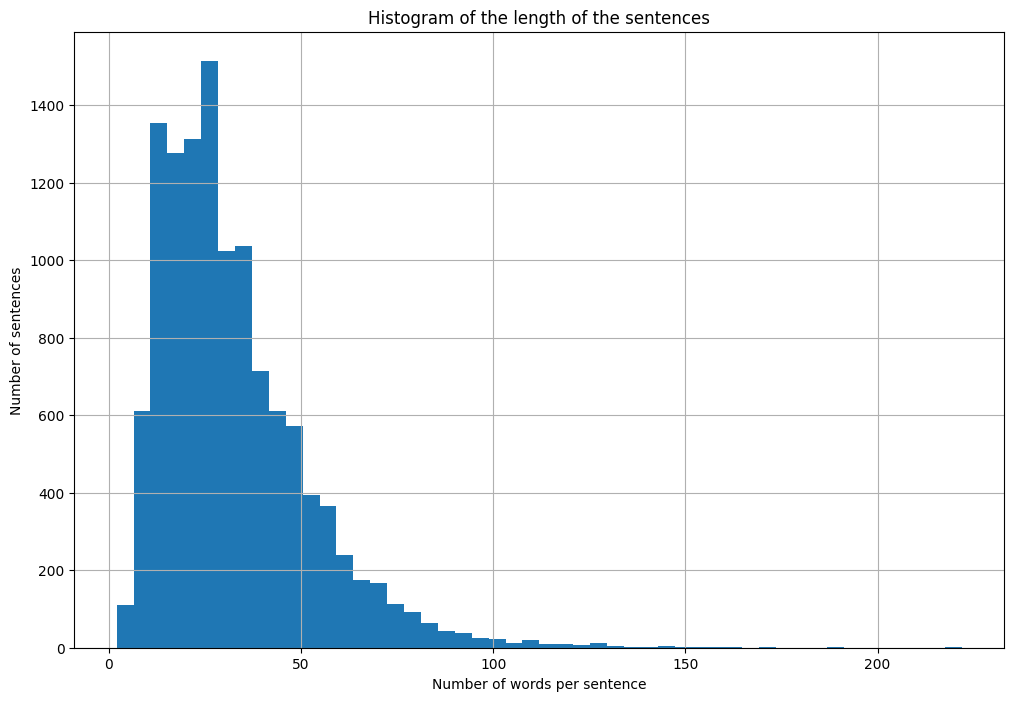

In [33]:
#Plot a histogram of the length of the sentences
import matplotlib.pyplot as plt
data_df.Sentence_ID.value_counts().hist(bins=50, figsize=(12, 8))
plt.title('Histogram of the length of the sentences')
plt.xlabel('Number of words per sentence')
plt.ylabel('Number of sentences')
plt.show()

We can see that the maximum number of tokens that appear in a sentence is 222 but the distribution of the sentence length has a mean around 32.

**4.2.2. Length analysis per text.** In that case the number of tokens per file can be obtain counting the times each File_ID appears in the DataFrame.

In [34]:
# Metrics for the length of the text in the data
data_df.File_ID.value_counts().describe(include='all')

count    1011.000000
mean      382.889219
std        93.521214
min       185.000000
25%       329.000000
50%       372.000000
75%       415.000000
max       986.000000
Name: count, dtype: float64

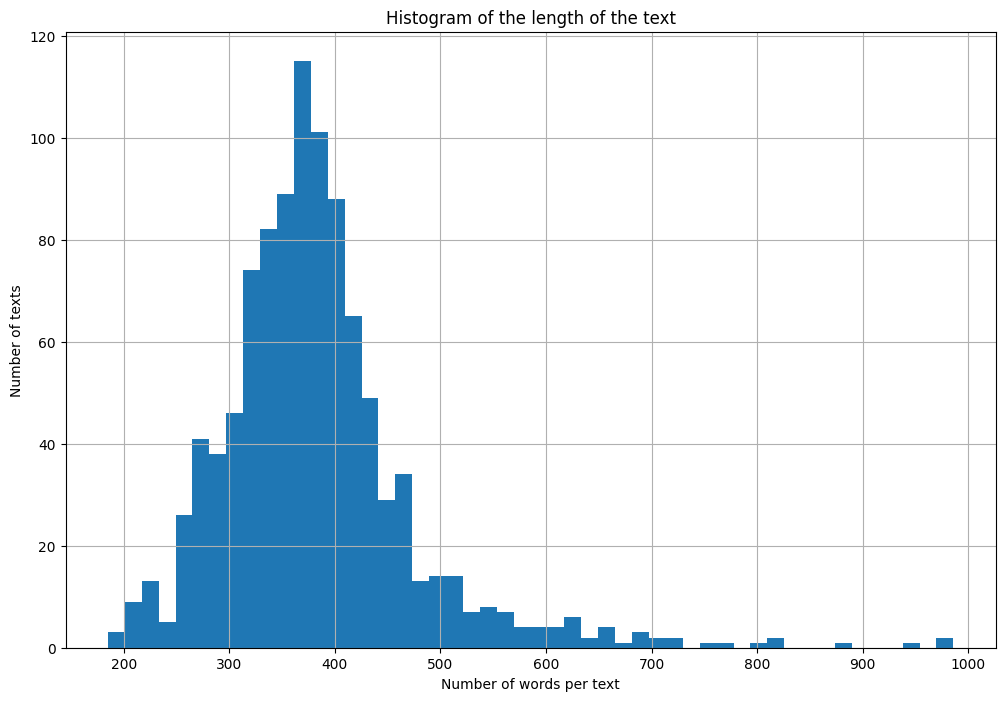

In [35]:
#Plot a histogram of the length of the sentences
import matplotlib.pyplot as plt
data_df.File_ID.value_counts().hist(bins=50, figsize=(12, 8))
plt.title('Histogram of the length of the text')
plt.xlabel('Number of words per text')
plt.ylabel('Number of texts')
plt.show()

Let see how many files hava length greater than 512.

In [36]:
print(f"The number of files with a length greater than 512 is: {sum(data_df.File_ID.value_counts() > 512)}")

The number of files with a length greater than 512 is: 74


These files should be splitted into two different files to be able to use the full text as input of the model. In case of using this approach the modification will be done after using the particular tokenizer of the model chosen. LongFormer model does not present any problem because works with a higher max_length value. When training BioBERT with the full texts the cases where the length is greater than 512 will be truncated to this size and information will be lost. To avoid that I prepare the data and split the texts previously. (Further work)

In [37]:
#Get File_IDs with a length greater than 512
file_ids = data_df.File_ID.value_counts()
file_ids = list(file_ids[file_ids > 512].index)

**5. Split into train/validation/test set**

To do that, I will extract from the list of File_ID 80% randomly to be the files of the train set and 10% for validation and test sets. Then, I will save the dataframes as dataBIO_train.txt, dataBIO_val.txt and dataBIO_test.txt

In [38]:
#Create a list of the fileID uniques
File_ID = data_df['File_ID'].unique()
File_ID

array(['24599578', '25275577', '12926095', ..., '26566950', '28084150',
       '17363187'], dtype=object)

In [39]:
#Choose randomly 80% of the File_ID indexes
import random
random.seed(42)
train = random.sample(list(File_ID), int(len(File_ID)*0.8))

#Create a list of the fileID indexes that are not in the train list
no_train = list(set(File_ID) - set(train))

#Choose randomly 50% of the File_ID indexes that are not in the train list
valid = random.sample(no_train, int(len(no_train)*0.5))

#Define test list
test = list(set(no_train) - set(valid))

#Comprobation of the length of the lists
print(f'Length of train set: {len(train)}') 
print(f'Length of validation set: {len(valid)}')
print(f'Length of test set: {len(test)}')
print(f'Total length: {len(train) + len(valid) + len(test)}')


Length of train set: 808
Length of validation set: 101
Length of test set: 102
Total length: 1011


In [40]:
#Generate the dataBIO dataframes for each set
train_df = data_df[data_df['File_ID'].isin(train)]
valid_df = data_df[data_df['File_ID'].isin(valid)]
test_df = data_df[data_df['File_ID'].isin(test)]

#Comprobation of the length of the dataframes
train_df['File_ID'].nunique(), valid_df['File_ID'].nunique(), test_df['File_ID'].nunique()

(808, 101, 102)

In [41]:
train_df

,File_ID,Entity,Start,End,Words,Sentence_ID
0,24599578,O,0,1,A,1
1,24599578,O,2,13,multicenter,1
2,24599578,O,14,24,randomized,1
3,24599578,O,25,30,trial,1
4,24599578,O,31,33,of,1
...,...,...,...,...,...,...
399063,17363187,O,1760,1765,local,11968
399064,17363187,O,1766,1769,and,11968
399065,17363187,O,1770,1777,overall,11968
399066,17363187,O,1778,1785,relapse,11968


**6. Analysis of the sets**

Now, we can compute how many elements each entity has in each of the sets.

In [42]:
Freq['train_set'] = train_df[train_df['Entity'] != 'O'].value_counts('Entity')
Freq['valid_set'] = valid_df[valid_df['Entity'] != 'O'].value_counts('Entity')
Freq['test_set'] = test_df[test_df['Entity'] != 'O'].value_counts('Entity')

Freq

,count,n_files,train_set,valid_set,test_set
Entity,,,,,
B-total-participants,1093,847,868,118,107.0
B-intervention-participants,887,674,714,86,87.0
B-control-participants,784,647,622,80,82.0
B-age,231,210,187,21,23.0
B-eligibility,925,864,732,101,92.0
B-ethinicity,101,83,73,23,5.0
B-condition,327,321,269,32,26.0
B-location,186,168,148,18,20.0
B-intervention,1067,1011,855,104,108.0


For each set I will define a dataFrame to know how many tokens are per field, how many sentences, ratios, etc.

In [44]:
train_info = GenerateInfoDF(train_df)
valid_info = GenerateInfoDF(valid_df)
test_info = GenerateInfoDF(test_df)

In [45]:
print('Train set information per file')
train_info

Train set information per file


,n_sentences,n_tokens,n_entities,n_unique_entities,ratio_entities_sentence,ratio_entities_token
File_ID,,,,,,
10459028,15,300,43,13,2.866667,0.143333
10547391,13,438,80,8,6.153846,0.182648
11283119,10,312,26,5,2.600000,0.083333
12374678,11,343,53,6,4.818182,0.154519
12377957,14,436,86,11,6.142857,0.197248
...,...,...,...,...,...,...
9060533,15,427,67,11,4.466667,0.156909
9363868,11,409,43,12,3.909091,0.105134
9626201,14,384,51,7,3.642857,0.132812


In [46]:
print('Train set statistics')
train_info.describe()

Train set statistics


,n_sentences,n_tokens,n_entities,n_unique_entities,ratio_entities_sentence,ratio_entities_token
count,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000
mean,12.861386,382.711634,59.732673,9.436881,4.775996,0.157020
std,2.868121,91.856751,25.420826,2.656451,2.074631,0.057499
min,6.000000,185.000000,10.000000,3.000000,0.769231,0.028818
25%,11.000000,328.000000,40.000000,7.000000,3.228632,0.115236
50%,13.000000,372.000000,56.000000,10.000000,4.464103,0.151668
75%,15.000000,414.000000,74.000000,11.000000,5.928571,0.191351
max,23.000000,980.000000,198.000000,17.000000,14.500000,0.375000


In [47]:
print('Validation set information per file')
valid_info

Validation set information per file


,n_sentences,n_tokens,n_entities,n_unique_entities,ratio_entities_sentence,ratio_entities_token
File_ID,,,,,,
12621740,12,268,41,17,3.416667,0.152985
15014181,12,354,51,11,4.250000,0.144068
15154664,8,254,55,8,6.875000,0.216535
15280341,15,380,66,12,4.400000,0.173684
15341559,11,371,60,6,5.454545,0.161725
...,...,...,...,...,...,...
32243029,13,357,61,8,4.692308,0.170868
32458473,13,337,62,10,4.769231,0.183976
32901672,14,327,92,11,6.571429,0.281346


In [48]:
print('Validation set statistics')
valid_info.describe()

Validation set statistics


,n_sentences,n_tokens,n_entities,n_unique_entities,ratio_entities_sentence,ratio_entities_token
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,12.821782,380.168317,58.970297,9.495050,4.788951,0.158616
std,3.278402,99.965301,23.393784,2.961836,1.905824,0.057312
min,6.000000,216.000000,14.000000,4.000000,0.777778,0.027290
25%,11.000000,330.000000,41.000000,7.000000,3.416667,0.115169
50%,12.000000,371.000000,60.000000,10.000000,4.769231,0.159686
75%,15.000000,411.000000,72.000000,11.000000,5.800000,0.193878
max,23.000000,986.000000,145.000000,19.000000,10.545455,0.316940


In [49]:
print('Test set information per file')
test_info

Test set information per file


,n_sentences,n_tokens,n_entities,n_unique_entities,ratio_entities_sentence,ratio_entities_token
File_ID,,,,,,
11136837,15,500,47,8,3.133333,0.094000
12393819,11,344,74,11,6.727273,0.215116
12721239,15,372,49,10,3.266667,0.131720
15117982,10,418,59,10,5.900000,0.141148
15179836,9,190,32,11,3.555556,0.168421
...,...,...,...,...,...,...
32416251,18,484,95,9,5.277778,0.196281
32718986,14,595,103,11,7.357143,0.173109
32954927,13,421,75,8,5.769231,0.178147


In [50]:
print('Test set statistics')
test_info.describe()

Test set statistics


,n_sentences,n_tokens,n_entities,n_unique_entities,ratio_entities_sentence,ratio_entities_token
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,12.656863,386.990196,56.117647,9.186275,4.584977,0.144941
std,3.216588,100.626306,25.715617,2.823979,2.223663,0.057454
min,7.000000,190.000000,14.000000,3.000000,1.272727,0.046997
25%,10.000000,332.750000,36.250000,7.000000,3.015625,0.097767
50%,12.500000,372.500000,50.000000,9.000000,4.170940,0.134692
75%,15.000000,420.500000,71.750000,11.000000,5.431818,0.175630
max,26.000000,819.000000,122.000000,20.000000,12.500000,0.383333


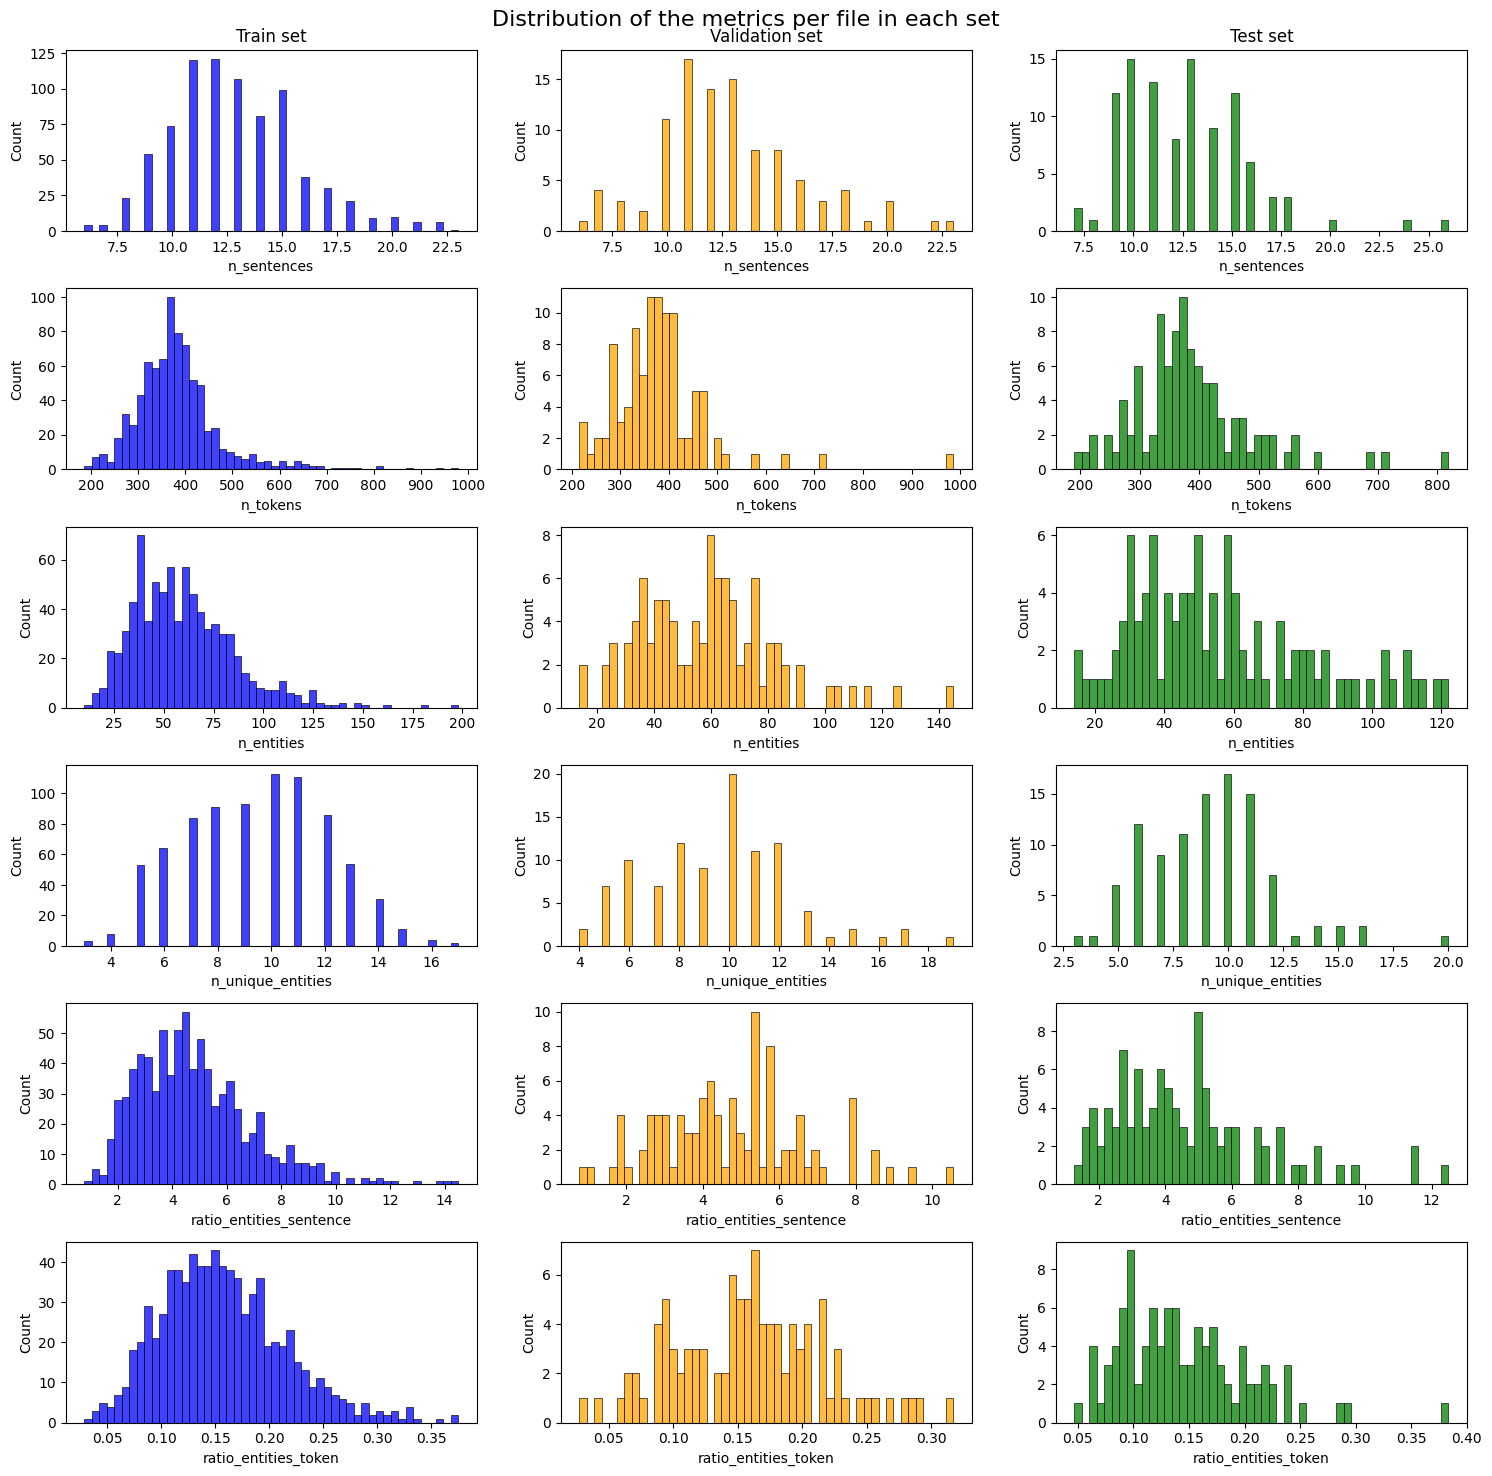

In [51]:
#Generate a plot with subfigures where each row is a column of the dataframe train_info and each column is a set (train, valid, test) and plot a histogram
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(6, 3, figsize=(15, 15))
fig.suptitle('Distribution of the metrics per file in each set', fontsize=16)

sns.histplot(ax=axes[0, 0], data=train_info, x='n_sentences', bins=50, color='blue')
axes[0, 0].set_title('Train set')
sns.histplot(ax=axes[0, 1], data=valid_info, x='n_sentences', bins=50, color='orange')
axes[0, 1].set_title('Validation set')
sns.histplot(ax=axes[0, 2], data=test_info, x='n_sentences', bins=50, color='green')
axes[0, 2].set_title('Test set')

sns.histplot(ax=axes[1, 0], data=train_info, x='n_tokens', bins=50, color='blue')   
sns.histplot(ax=axes[1, 1], data=valid_info, x='n_tokens', bins=50, color='orange')
sns.histplot(ax=axes[1, 2], data=test_info, x='n_tokens', bins=50, color='green')

sns.histplot(ax=axes[2, 0], data=train_info, x='n_entities', bins=50, color='blue')
sns.histplot(ax=axes[2, 1], data=valid_info, x='n_entities', bins=50, color='orange')
sns.histplot(ax=axes[2, 2], data=test_info, x='n_entities', bins=50, color='green')

sns.histplot(ax=axes[3, 0], data=train_info, x='n_unique_entities', bins=50, color='blue')
sns.histplot(ax=axes[3, 1], data=valid_info, x='n_unique_entities', bins=50, color='orange')
sns.histplot(ax=axes[3, 2], data=test_info, x='n_unique_entities', bins=50, color='green')

sns.histplot(ax=axes[4, 0], data=train_info, x='ratio_entities_sentence', bins=50, color='blue')
sns.histplot(ax=axes[4, 1], data=valid_info, x='ratio_entities_sentence', bins=50, color='orange')
sns.histplot(ax=axes[4, 2], data=test_info, x='ratio_entities_sentence', bins=50, color='green')

sns.histplot(ax=axes[5, 0], data=train_info, x='ratio_entities_token', bins=50, color='blue')
sns.histplot(ax=axes[5, 1], data=valid_info, x='ratio_entities_token', bins=50, color='orange')
sns.histplot(ax=axes[5, 2], data=test_info, x='ratio_entities_token', bins=50, color='green')

#Define the distance between the subplots
plt.tight_layout(pad=1.0)

plt.show()





We can conclude that the distribution of the considered metrics are similar in the validation and test set in all the cases which is important in order to analyse once the models are fine-tuned the capacity of generalization. The metrics are different to the train set results. However, this is not necessarely a problem and it will be probably caused by the considerably higher number of files in the set.

**7. Prepare data to pass it to the model**

Depending on the approach chosen the model will receive an input per text or an input per sentence of each text.

In [53]:
#Sentences considered as a unique sample
entry_param = "sentence" #complete/sentence
df_train_processed = PreprocessingData(train_df, entry_param)
df_valid_processed = PreprocessingData(valid_df, entry_param)
df_test_processed = PreprocessingData(test_df, entry_param)

/tmp/ipykernel_6274/2619656120.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentence'] = df.groupby(['Sentence_ID'])['Words'].transform(lambda x: ' '.join(x))
/tmp/ipykernel_6274/2619656120.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Entity_sentence'] = df.groupby(['Sentence_ID'])['Entity'].transform(lambda x: ' '.join(x))
/tmp/ipykernel_6274/2619656120.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [54]:
print(f"Number of unique rows in train set: {train_df['Sentence_ID'].nunique()}")
print(f"Number of unique rows in train set processed: {df_train_processed['Sentence_ID'].nunique()}")
print(f"Number of unique rows in valid set: {valid_df['Sentence_ID'].nunique()}")
print(f"Number of unique rows in valid set processed: {df_valid_processed['Sentence_ID'].nunique()}")
print(f"Number of unique rows in test set: {test_df['Sentence_ID'].nunique()}")
print(f"Number of unique rows in test set processed: {df_test_processed['Sentence_ID'].nunique()}")

df_train_processed.head()


Number of unique rows in train set: 9746
Number of unique rows in train set processed: 9746
Number of unique rows in valid set: 1286
Number of unique rows in valid set processed: 1286
Number of unique rows in test set: 1279
Number of unique rows in test set processed: 1279


,Sentence_ID,Sentence,Entity_sentence
0,1,A multicenter randomized trial of the effects ...,O O O O O O O O B-intervention O O O O B-condi...
1,2,Exercise may improve psychosocial distress in ...,O O O O O O O O O O O O O O O O O O O O O O O ...
2,3,"In a multicenter trial in Canada , we randomiz...",O O O O O B-location O O O B-total-participant...
3,4,The primary endpoint was depression assessed b...,O O O O B-outcome-Measure O O O O O O O O O O ...
4,5,"Secondary endpoints were anxiety , perceived s...",O O O B-outcome-Measure O B-outcome-Measure I-...


In [55]:
#Case of complete text
df_train_processed_full = PreprocessingData(train_df)
df_valid_processed_full = PreprocessingData(valid_df)
df_test_processed_full = PreprocessingData(test_df)

/tmp/ipykernel_6274/2619656120.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentence'] = df.groupby(['File_ID'])['Words'].transform(lambda x: ' '.join(x))
/tmp/ipykernel_6274/2619656120.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Entity_sentence'] = df.groupby(['File_ID'])['Entity'].transform(lambda x: ' '.join(x))
/tmp/ipykernel_6274/2619656120.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [56]:
print(f"Number of unique rows in train set: {train_df['File_ID'].nunique()}")
print(f"Number of unique rows in train set processed: {df_train_processed_full['File_ID'].nunique()}")
print(f"Number of unique rows in valid set: {valid_df['File_ID'].nunique()}")
print(f"Number of unique rows in valid set processed: {df_valid_processed_full['File_ID'].nunique()}")
print(f"Number of unique rows in test set: {test_df['File_ID'].nunique()}")
print(f"Number of unique rows in test set processed: {df_test_processed_full['File_ID'].nunique()}")

df_train_processed_full.head()

Number of unique rows in train set: 808
Number of unique rows in train set processed: 808
Number of unique rows in valid set: 101
Number of unique rows in valid set processed: 101
Number of unique rows in test set: 102
Number of unique rows in test set processed: 102


,File_ID,Sentence,Entity_sentence
0,24599578,A multicenter randomized trial of the effects ...,O O O O O O O O B-intervention O O O O B-condi...
1,12926095,Bone turnover markers and insulin - like growt...,O O O O O O O O O O O O O O O O O O O O O B-in...
2,24421054,Effect of β - glucan on drain fluid and amount...,O O B-intervention I-intervention I-interventi...
3,19281053,Managing the risk of invasive breast cancer in...,O O O O O O O O O O O O O O O O O O O O B-inte...
4,27336726,Ribociclib plus letrozole in early breast canc...,B-intervention I-intervention I-intervention O...


**7. Save the BIO dataFrames for each set and train/val/test sets processed**

In [58]:
train_df.to_csv('./DataProcessed/trainBIO.csv', sep=' ', index=False)
valid_df.to_csv('./DataProcessed/validBIO.csv', sep=' ', index=False)
test_df.to_csv('./DataProcessed/testBIO.csv', sep=' ', index=False)

In [59]:
df_valid_processed_full.to_csv('./DataProcessed/valid_full_text.csv', sep=' ', index=False)
df_train_processed_full.to_csv('./DataProcessed/train_full_text.csv', sep=' ', index=False)
df_test_processed_full.to_csv('./DataProcessed/test_full_text.csv', sep=' ', index=False)

df_valid_processed.to_csv('./DataProcessed/valid_sentences.csv', sep=' ', index=False)
df_train_processed.to_csv('./DataProcessed/train_sentences.csv', sep=' ', index=False)
df_test_processed.to_csv('./DataProcessed/test_sentences.csv', sep=' ', index=False)

**8. Create the DataSet.**

In [73]:
#Load data from csv files

path_train = "./DataProcessed/train_full_text.csv"
path_valid = "./DataProcessed/valid_full_text.csv"
path_test  = "./DataProcessed/test_full_text.csv"

import pandas as pd

def load_data(path):
    #Read csv file specifying that the first row is the header
    df = pd.read_csv(path, sep=" ", header=0)
    return df

train = load_data(path_train)
valid = load_data(path_valid)
test  = load_data(path_test)

I split the elements of each sentence (or text) and save it in a list.

In [75]:
words_train, words_labels_train = SplitData(train)
words_valid, words_labels_valid = SplitData(valid)
words_test, words_labels_test = SplitData(test)

Number of sentences:  808
Number of labels:  808
Number of sentences:  101
Number of labels:  101
Number of sentences:  102
Number of labels:  102


Map the words_labels into int values.

In [76]:
#Define the tags
data = pd.read_csv("./DataProcessed/dataBIO_v3.txt", sep=",", header=None, names = ['File_ID', 'Entity', 'Start', 'End', 'Words', 'Sentence_ID']) 
tag_values = list(set(data["Entity"].values))

tag2idx = {t: i for i, t in enumerate(tag_values)}
idx2tag = {i: t for i, t in enumerate(tag_values)}

print(tag2idx)
print(idx2tag)

{'B-intervention-participants': 0, 'B-cv-bin-abs': 1, 'B-cv-cont-q3': 2, 'B-cv-bin-percent': 3, 'B-ethinicity': 4, 'I-eligibility': 5, 'I-iv-cont-q3': 6, 'B-cv-cont-q1': 7, 'B-cv-cont-median': 8, 'B-outcome': 9, 'I-cv-cont-mean': 10, 'I-iv-bin-abs': 11, 'I-cv-bin-abs': 12, 'B-cv-cont-mean': 13, 'B-cv-cont-sd': 14, 'B-age': 15, 'B-total-participants': 16, 'I-condition': 17, 'B-iv-cont-q1': 18, 'I-iv-bin-percent': 19, 'I-outcome': 20, 'Entity': 21, 'B-iv-bin-percent': 22, 'B-condition': 23, 'B-outcome-Measure': 24, 'I-iv-cont-mean': 25, 'I-intervention': 26, 'I-cv-cont-sd': 27, 'B-iv-bin-abs': 28, 'I-location': 29, 'B-iv-cont-q3': 30, 'I-age': 31, 'I-cv-cont-q3': 32, 'B-control': 33, 'B-intervention': 34, 'B-iv-cont-mean': 35, 'I-iv-cont-median': 36, 'B-eligibility': 37, 'B-iv-cont-median': 38, 'O': 39, 'I-intervention-participants': 40, 'I-outcome-Measure': 41, 'B-iv-cont-sd': 42, 'I-cv-bin-percent': 43, 'I-control-participants': 44, 'I-ethinicity': 45, 'I-total-participants': 46, 'B-co

/tmp/ipykernel_6274/1433176295.py:2: DtypeWarning: Columns (0,2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./DataProcessed/dataBIO_v3.txt", sep=",", header=None, names = ['File_ID', 'Entity', 'Start', 'End', 'Words', 'Sentence_ID'])


In [79]:
#Map the labels to the tags
labels_train = MapLabels(words_labels_train, tag2idx)
labels_valid = MapLabels(words_labels_valid, tag2idx)
labels_test  = MapLabels(words_labels_test, tag2idx)

In [81]:
#Create a dataset for each set
train_dataset = CreateDataset(words_train, labels_train, tag_values)
valid_dataset = CreateDataset(words_valid, labels_valid, tag_values)
test_dataset  = CreateDataset(words_test, labels_test, tag_values)

train_dataset.features


{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['B-intervention-participants', 'B-cv-bin-abs', 'B-cv-cont-q3', 'B-cv-bin-percent', 'B-ethinicity', 'I-eligibility', 'I-iv-cont-q3', 'B-cv-cont-q1', 'B-cv-cont-median', 'B-outcome', 'I-cv-cont-mean', 'I-iv-bin-abs', 'I-cv-bin-abs', 'B-cv-cont-mean', 'B-cv-cont-sd', 'B-age', 'B-total-participants', 'I-condition', 'B-iv-cont-q1', 'I-iv-bin-percent', 'I-outcome', 'Entity', 'B-iv-bin-percent', 'B-condition', 'B-outcome-Measure', 'I-iv-cont-mean', 'I-intervention', 'I-cv-cont-sd', 'B-iv-bin-abs', 'I-location', 'B-iv-cont-q3', 'I-age', 'I-cv-cont-q3', 'B-control', 'B-intervention', 'B-iv-cont-mean', 'I-iv-cont-median', 'B-eligibility', 'B-iv-cont-median', 'O', 'I-intervention-participants', 'I-outcome-Measure', 'B-iv-cont-sd', 'I-cv-bin-percent', 'I-control-participants', 'I-ethinicity', 'I-total-participants', 'B-control-parti

In [82]:
dataset = {"train": train_dataset, "valid": valid_dataset, "test": test_dataset}

#Transform dataset dict into a dataset object
from datasets import DatasetDict

dataset = DatasetDict(dataset)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 808
    })
    valid: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 101
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 102
    })
})

In [83]:
#Save the dataset
dataset.save_to_disk("./DataProcessed/dataset_full_text")

Saving the dataset (0/1 shards):   0%|          | 0/808 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/101 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/102 [00:00<?, ? examples/s]

**9. Push the Dataset to HuggingFace.**

In [84]:
#huggingface-cli login (in terminal)
from huggingface_hub import notebook_login
notebook_login()
dataset.push_to_hub("cuevascarlos/PICO-breast-cancer")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/2.14k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/cuevascarlos/PICO-breast-cancer/commit/e667f922541b306e377cc4b614c6356bb9b63185', commit_message='Upload dataset', commit_description='', oid='e667f922541b306e377cc4b614c6356bb9b63185', pr_url=None, pr_revision=None, pr_num=None)